In [1]:
# autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

import pathmagic
from tools.project import proj_dir

In [2]:
import torch

In [3]:
from tools.tools import load_tensor_image, load_blender_flow_exr, to_tensor_crop
from tools.vis_tools import visualize_tensors, flow_to_vis
import matplotlib.pyplot as plt

#folder = "/home/kevin/Documents/master-thesis/render/DiningRoom1"
folder = "/home/kevin/Documents/master-thesis/datasets/s7_test_allinfocus/test/seq0"

size = 256

img0 = load_tensor_image(os.path.join(folder, "allinfocus0000.tif"), size).cuda()
img1 = load_tensor_image(os.path.join(folder, "allinfocus0001.tif"), size).cuda()

flow_gt = load_blender_flow_exr(os.path.join(folder, "flow0000.exr"))
flow_gt = to_tensor_crop(flow_gt, size).cuda()

/home/kevin/miniconda2/envs/torch/lib/python3.6/site-packages/torch/cuda/__init__.py:118: UserWarning: 
    Found GPU0 GeForce GTX 660M which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


/home/kevin/miniconda2/envs/torch/lib/python3.6/site-packages/torch/nn/functional.py:2493: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([2, 256, 256])
torch.Size([2, 256, 256])
torch.Size([3, 256, 256])


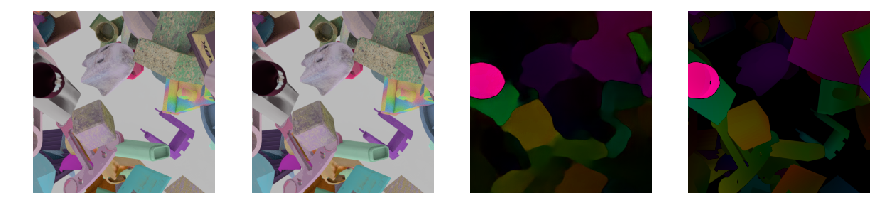

In [4]:
from net.flownet2 import FlowNet2, load_flownet_nvidia

with torch.no_grad():
    net = FlowNet2().cuda()
    net.eval()
    load_flownet_nvidia(net)
    
    flow = net(torch.stack([img0, img1], dim=0).unsqueeze(0))[0]

print(flow.shape)
print(flow_gt.shape)

flow_vis = flow_to_vis(flow)
flow_gt_vis = flow_to_vis(flow_gt)

print(flow_vis.size())

plt.figure(figsize=(15,15))
visualize_tensors([[img0, img1, flow_vis, flow_gt_vis]])

torch.Size([3, 256, 256])
torch.Size([2, 256, 256])
tensor(0.8903, device='cuda:0')
Diff tensor(0.0035, device='cuda:0')
Calc tensor(0.0021, device='cuda:0')
GT tensor(0.0029, device='cuda:0')


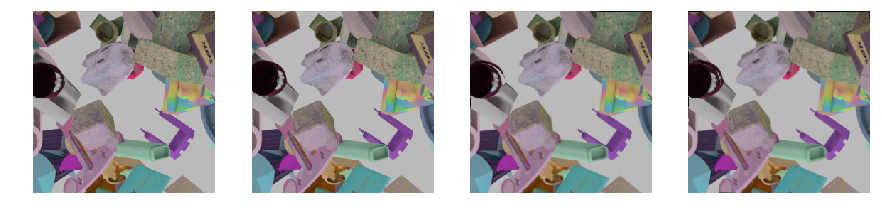

In [5]:
from net.flownet2 import Warp
from torch import nn

print(img1.shape)
print(flow_gt.shape)

warp = Warp()

img1 = img1.cuda()
flow = flow.cuda()

#warp(img1.contiguous(), flow_gt.contiguous())
img1_to_img0 = warp(img1.unsqueeze(0).contiguous(), flow.unsqueeze(0).contiguous())[0].detach()
img1_to_img0_gt = warp(img1.unsqueeze(0).contiguous(), flow_gt.unsqueeze(0).contiguous())[0].detach()

print(img1_to_img0.max())

mse = nn.MSELoss()

print("Diff", mse(img0, img1))
print("Calc", mse(img0, img1_to_img0))
print("GT", mse(img0, img1_to_img0_gt))

plt.figure(figsize=(15,15))
visualize_tensors([[img0, img1, img1_to_img0, img1_to_img0_gt]])

In [6]:
import torch
torch.rand(5).cuda().is_cuda

True

In [7]:
from tools.tools import load_tensor_image, load_blender_flow_exr, to_tensor_crop, load_tensor_depth
from tools.vis_tools import visualize_tensors, flow_to_vis
import matplotlib.pyplot as plt
from net.flownet2 import Warp
from torch import nn
import torch
from net.flownet2 import FlowNet2, load_flownet_nvidia


warp = Warp()
warp_nvid = Warp(use_nvidia=True)
mse = nn.MSELoss()
    
#folder = "/home/kevin/Documents/master-thesis/render/DiningRoom1"
# folder = "/home/kevin/Documents/master-thesis/render/flow_comb2"
folder = "/home/kevin/Documents/master-thesis/datasets/s7_5ramp/train/seq0"

size = 256

# img0 = load_tensor_image(os.path.join(folder, "allinfocus0000.tif"), size).cuda()
# img1 = load_tensor_image(os.path.join(folder, "allinfocus0001.tif"), size).cuda()
# img2 = load_tensor_image(os.path.join(folder, "allinfocus0002.tif"), size).cuda()

img0 = load_tensor_depth(os.path.join(folder, "depth0000.exr"), size).cuda()
img1 = load_tensor_depth(os.path.join(folder, "depth0001.exr"), size).cuda()
img2 = load_tensor_depth(os.path.join(folder, "depth0002.exr"), size).cuda()

print(img0.shape, img1.shape, img2.shape)

flow01 = to_tensor_crop(load_blender_flow_exr(os.path.join(folder, "flow0000.exr")), size).cuda()
flow12 = to_tensor_crop(load_blender_flow_exr(os.path.join(folder, "flow0001.exr")), size).cuda()
# flow_comb = to_tensor_crop(load_blender_flow_exr(os.path.join(folder, "flow0000_comb.exr")), size).cuda()

with torch.no_grad():
    net = FlowNet2().cuda()
    net.eval()
    load_flownet_nvidia(net)
    
    flow01_comp = net(torch.stack([img0, img1], dim=0).unsqueeze(0))[0]
    flow12_comp = net(torch.stack([img1, img2], dim=0).unsqueeze(0))[0]
    
print("End")

torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
End


torch.Size([1, 256, 256])
tensor(6999.5732, device='cuda:0')


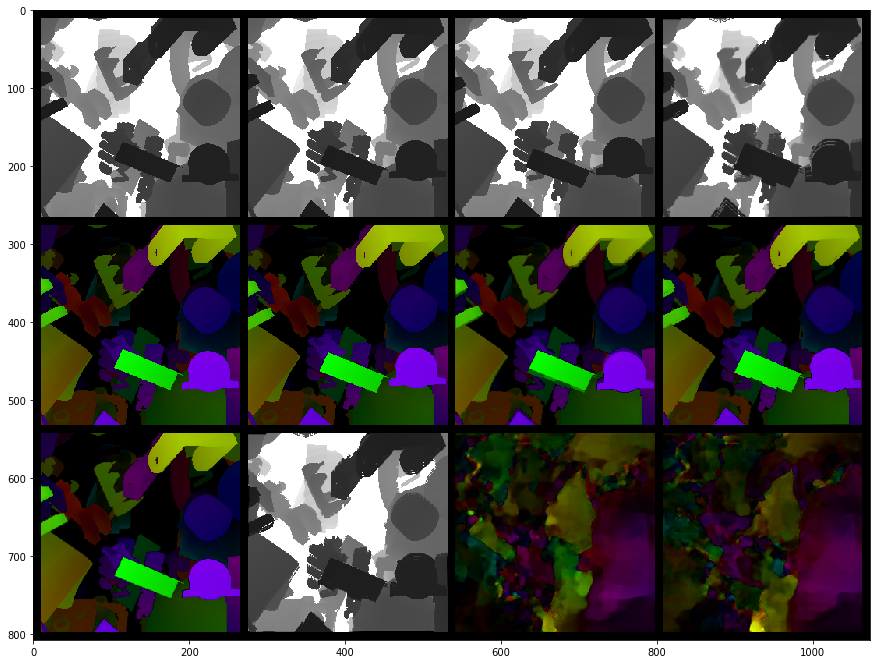

In [8]:
from net.flownet2 import MultiWarp, FlowComposite, FlowTrajectory, Warp
from tools.vis_tools import plot_tensor_grid

flows = torch.stack([flow01, flow12]).unsqueeze(0)

"""
img_2_to_1 = warp_nvid(img2.unsqueeze(0), flow12.unsqueeze(0))[0]
img_1_to_0 = warp_nvid(img_2_to_1.unsqueeze(0), flow01.unsqueeze(0))[0]

img_2_to_1_nvid = warp_nvid(img2.unsqueeze(0), flow12.unsqueeze(0))[0]
img_2_to_1_comp_nvid = warp_nvid(img2.unsqueeze(0), flow12_comp.unsqueeze(0))[0]
"""

# flow02 = combine_flow(flow01, flow12)

warp = Warp()
multi_warp_composite_flow = MultiWarp(use_composite_flow=True)
multi_warp = MultiWarp(use_composite_flow=False)

#print(mse(img2, img1).sqrt())
#print(mse(flow02, flow_comb))
#print(((img_1_to_0 - img_2_to_0)**2).sum())

img_1_to_0 = warp(img1.unsqueeze(0), flow01.unsqueeze(0))[0]

img_2_to_0 = multi_warp(img2.unsqueeze(0), flows)[0]
img_2_to_0_composite_flow = multi_warp_composite_flow(img2.unsqueeze(0), flows)[0]
print(img_2_to_0.shape)

print(((img_2_to_0 - img_2_to_0_composite_flow)**2).sum())

flow02 = FlowComposite()(torch.stack([flow01, flow12]).unsqueeze(0))[0]

flow_traj = FlowTrajectory()(torch.stack([flow01, flow12]).unsqueeze(0))[0]

plt.figure(figsize=(15,15))
plot_tensor_grid([
    img0, img1, img2, img_2_to_0, 
    
    flow_to_vis(flow01), flow_to_vis(flow12), flow_to_vis(flow02), flow_to_vis(flow_traj[1]), flow_to_vis(flow_traj[0]), 
    img_2_to_0_composite_flow, flow_to_vis(flow01_comp), flow_to_vis(flow12_comp), 
], nrow=4)
#visualize_tensors([[img_2_to_1, flow_to_vis(flow01), flow_to_vis(flow12), flow_to_vis(flow_comb), flow_to_vis(flow02)]])

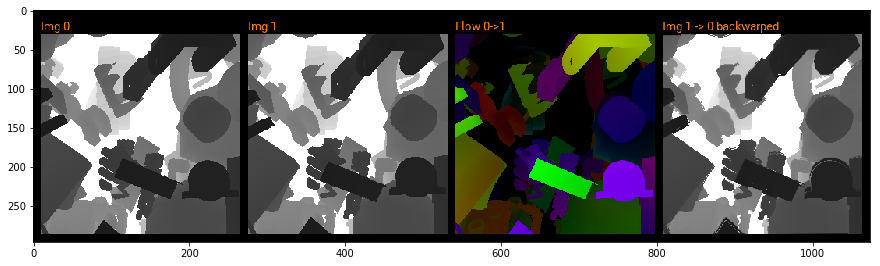

In [9]:
plot_tensor_grid(
    tensors=[img0, img1, flow_to_vis(flow01), img_1_to_0],
    titles=["Img 0", "Img 1", "Flow 0->1", "Img 1 -> 0 backwarped"],
    nrow=4, figsize=[15, 8], save_path="~/img.tiff")

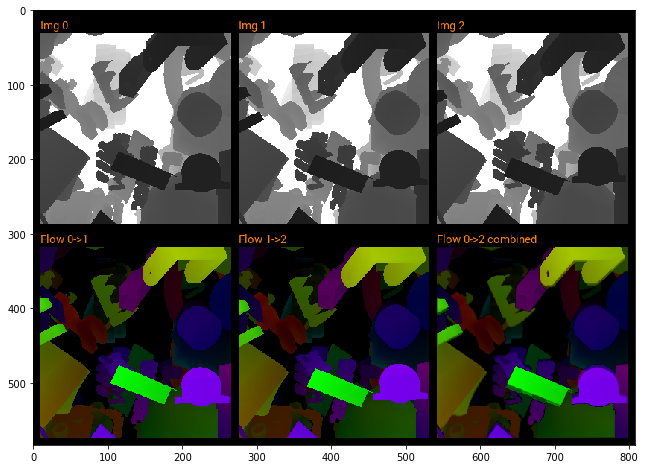

In [10]:
plot_tensor_grid([
    img0, img1, img2,
    flow_to_vis(flow01), flow_to_vis(flow12), flow_to_vis(flow02)
], 
    titles=["Img 0", "Img 1", "Img 2", "Flow 0->1", "Flow 1->2", "Flow 0->2 combined"],
    nrow=3, figsize=[15, 8], save_path="~/img.tiff")

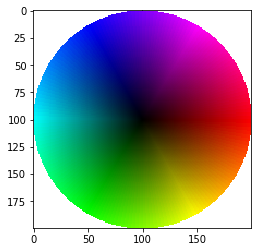

In [11]:
from tools.vis_tools import plot_flow_circle

plot_flow_circle(save_path="~/flow_circle.tiff")

In [12]:
print(torch.version.cuda)

9.2.148
